# Test HC37 and 38 annotation file
- Megan corrected annotation files that were switched during upload of HC37 and HC38
- Check each activity and plot for each subject
- Everything looks good. All tasks plotted for each subject below.

# Dependencies

In [1]:
# Importing the Libraries
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import time
import re
import copy
%matplotlib inline

In [8]:
def unstack_ar_dictionary(act_dict):
    """Takes a 4-level nested dictionary and unstacks into a activity recognition dataframe."""
    df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
    df.columns = ['task','trial','location','sensor','rawdata']
    return df

def extract_date_from_timestamp(timestamp):
    """Convert UNIX to Timestamp data type and cleanup timestamp dataframe
    Input: Dataframe with timestamp annotations in UNIX time in milliseconds
    Output: Dataframe with tasks
    """
    timestamp.reset_index(inplace=True)
    timestamp.insert(1,'date',pd.to_datetime(timestamp['Start Timestamp (ms)'], unit='ms'))
    timestamp.drop(timestamp.columns[[2,3]], inplace=True, axis=1)
    # adjust trial number to start from 0
    timestamp.Trial = timestamp.Trial - 1
    # keep date only in date column
    timestamp.date = timestamp.date.dt.date
    # rename columns
    timestamp.rename(index=str, columns={'Value':'task', 'Trial':'trial'}, inplace=True)
    
    return timestamp

def process_annotations(path):
    """
    Processes raw annotations file to extract start / end timestamps and remove unnecessary data
    Inputs:  path - filepath of the subject folder containing annotations.csv
    Outputs: df - dataframe containing list of activities and their start / end timestamps
    """
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    # subset Activity Recognition data by partially match EventType string
    df = df[df['EventType'].str.match('Activity')]
    del df['EventType']
    df.Value = df.Value.shift(-1)
    df = df.dropna()
    
    # Create Trial column for Value
    sorter = set(df.Value.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))        
    df['Value_Rank'] = df['Value'].map(sorterIndex)
    df['Trial'] = df.groupby('Value')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['Value_Rank']
    df = df.reset_index(drop=True).set_index('Value')
    
    return df

def onesubject_meta_raw(dictionary_path, annotation_path, subj):
    """
    Combines the metadata and rawdata into a dataframe before filtering and feature extraction.
    The selected subject's pickle file containing nested dictionary of raw AR data is loaded.
    The dates from the annotation file are added to the final dataframe's metadata.
    
    Functions called:
    process_annotations()
    extract_date_from_timestamp()
    unstack_ar_dictionary()
    
    Input:
    dictionary_path - path that contains the raw data with metadata in nested dictionary format
    annotation_path - path that holds the annotation timestamps that contains the date metadata
    subj - 4 character string ID for subject
    
    Output: Dataframe with metadata (subject, date, test, task, trial, location, sensor)
        and raw data. This dataframe is ready for filtering and feature extraction.
     
    Example: 
    dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
    annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
    subj = 'HC02'
    df = onesubject_meta_raw(dictionary_path, annotation_path, subj)
    """
    # use context manager to reload pickle file
    filename = os.path.join(dictionary_path, subj + 'dict.pkl')
    with open(filename,'rb') as filename:
        act_dict = pickle.load(filename)

    # get timestamp info for feature matrix
    subject_annotation_path = os.path.join(annotation_path, subj)
    timestamp = process_annotations(subject_annotation_path)
    timestamp = extract_date_from_timestamp(timestamp)

    # unstack nested dictionary structure
    df = unstack_ar_dictionary(act_dict)
    # add metadata
    df.insert(0,'subject',subj)
    df.insert(1,'test','activity recognition')
    # merge date data from timestamps
    df = pd.merge(df, timestamp, on=['task','trial'])
    # move date column to 2nd column position
    cols = list(df)
    cols.insert(1, cols.pop(cols.index('date')))
    df = df.loc[:, cols]
    
    return df

# Repeat data extraction with annotation file PRN

In [ ]:
#create data dict for remaining subjects
data_all = []

for SubID in ['HC37', 'HC38']:
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    
    #save dict to Pickle file
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    #filename = SubID + 'dict.pkl' # will need to move to Y: drive
    with open(filename,'wb') as f:
        pickle.dump(act_dict,f)
    print(filename + ' ' + 'File Saved\n')

# Load data for HC 37 and 38

## Load HC37

In [46]:
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
subj = 'HC37'
df37 = onesubject_meta_raw(dictionary_path, annotation_path, subj)

## Load HC38

In [47]:
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
subj = 'HC38'
df38 = onesubject_meta_raw(dictionary_path, annotation_path, subj)

# Check HC37 activity recognition data

In [26]:
df37.query('sensor=="accel" and location=="sacrum"')

,subject,date,test,task,trial,location,sensor,rawdata
39,HC37,2018-07-31,activity recognition,LYING,0,sacrum,accel,"Empty DataFrame Columns: [Accel X (g), Accel Y..."
87,HC37,2018-07-31,activity recognition,LYING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
135,HC37,2018-07-31,activity recognition,LYING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
183,HC37,2018-07-31,activity recognition,SITTING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
231,HC37,2018-07-31,activity recognition,SITTING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
279,HC37,2018-07-31,activity recognition,SITTING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
327,HC37,2018-07-31,activity recognition,SITTING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...
375,HC37,2018-07-31,activity recognition,STANDING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
423,HC37,2018-07-31,activity recognition,STANDING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
471,HC37,2018-07-31,activity recognition,STANDING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...


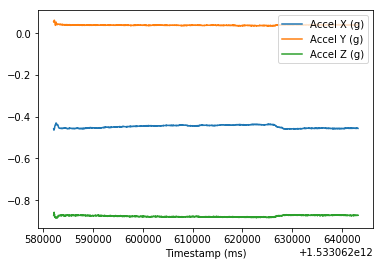

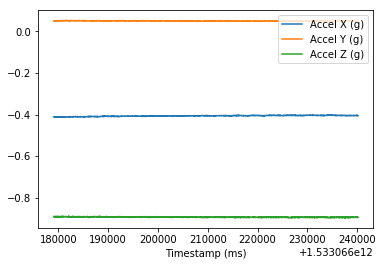

In [32]:
# lying
df37.rawdata[87].plot()
df37.rawdata[135].plot()

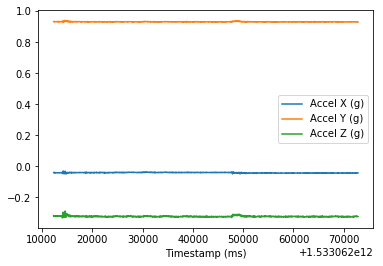

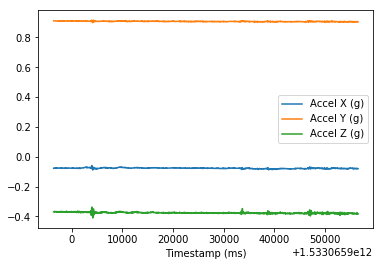

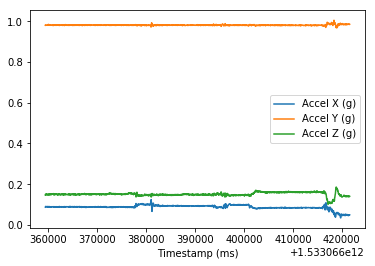

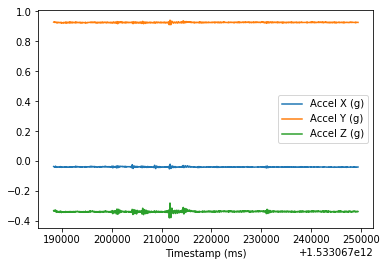

In [34]:
# sitting
df37.rawdata[183].plot()
df37.rawdata[231].plot()
df37.rawdata[279].plot()
df37.rawdata[327].plot()

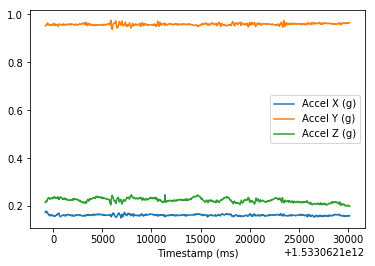

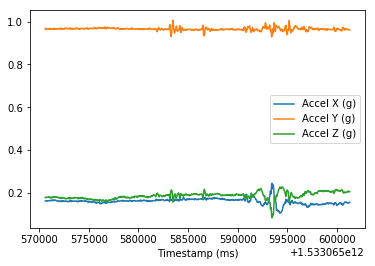

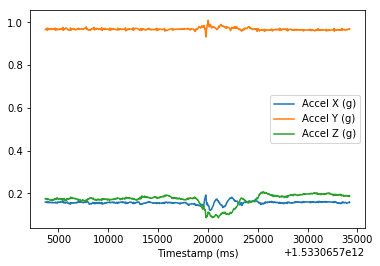

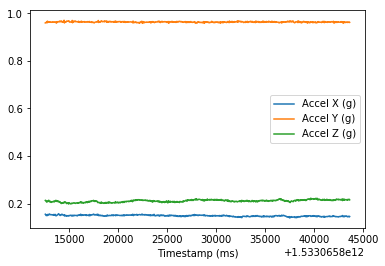

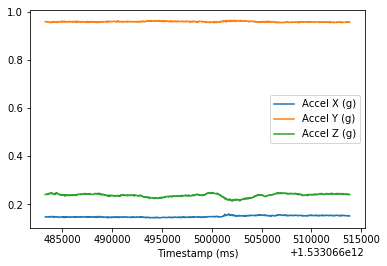

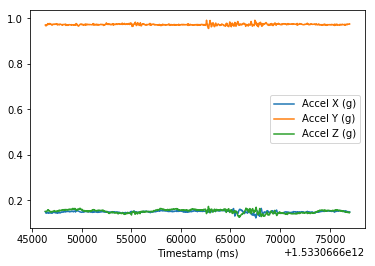

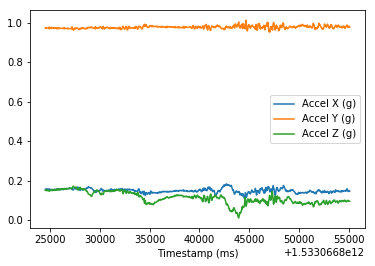

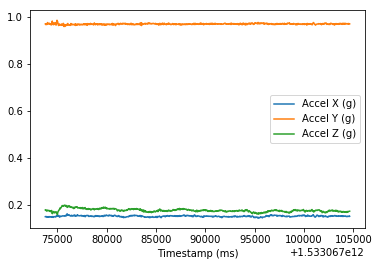

In [33]:
# standing
df37.rawdata[375].plot()
df37.rawdata[423].plot()
df37.rawdata[471].plot()
df37.rawdata[519].plot()
df37.rawdata[567].plot()
df37.rawdata[615].plot()
df37.rawdata[663].plot()
df37.rawdata[711].plot()

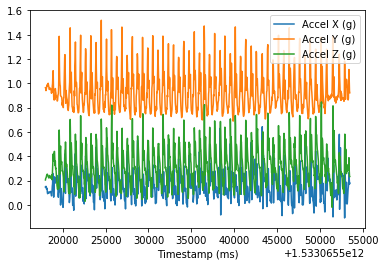

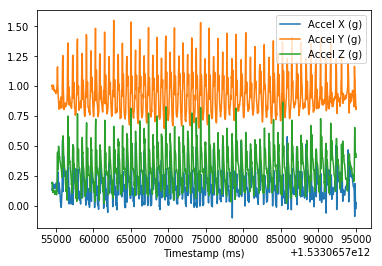

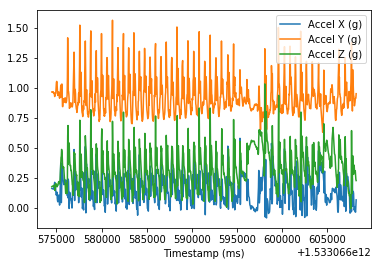

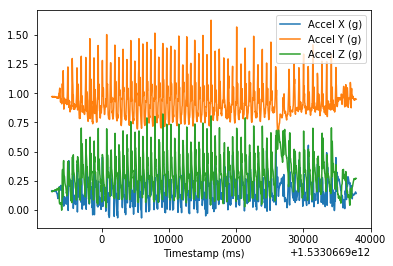

In [35]:
# walking
df37.rawdata[759].plot()
df37.rawdata[807].plot()
df37.rawdata[855].plot()
df37.rawdata[903].plot()

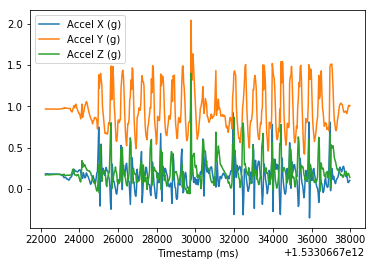

In [37]:
# stairs down
# df37.rawdata[951].plot()
df37.rawdata[999].plot()

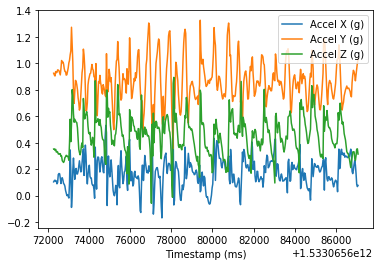

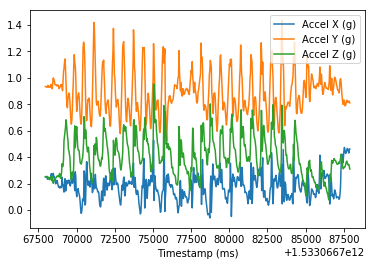

In [38]:
# stairs up
df37.rawdata[1047].plot()
df37.rawdata[1095].plot()

# Check HC38 activity recognition data

In [39]:
df38.query('sensor=="accel" and location=="sacrum"')

,subject,date,test,task,trial,location,sensor,rawdata
39,HC38,2018-07-31,activity recognition,LYING,0,sacrum,accel,"Empty DataFrame Columns: [Accel X (g), Accel Y..."
87,HC38,2018-07-31,activity recognition,LYING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
135,HC38,2018-07-31,activity recognition,LYING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
183,HC38,2018-07-31,activity recognition,SITTING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
231,HC38,2018-07-31,activity recognition,SITTING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
279,HC38,2018-07-31,activity recognition,SITTING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
327,HC38,2018-07-31,activity recognition,SITTING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...
375,HC38,2018-07-31,activity recognition,STANDING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
423,HC38,2018-07-31,activity recognition,STANDING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
471,HC38,2018-07-31,activity recognition,STANDING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...


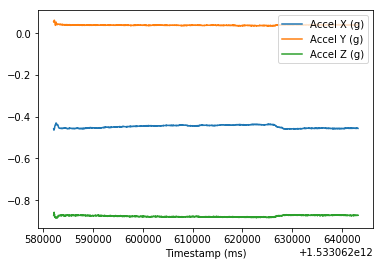

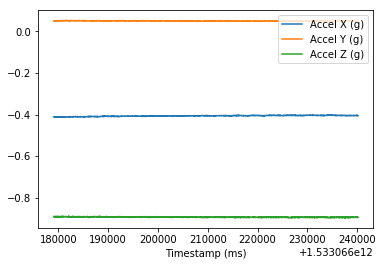

In [43]:
# lying
df37.rawdata[87].plot()
df37.rawdata[135].plot()

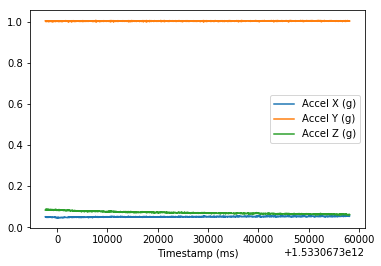

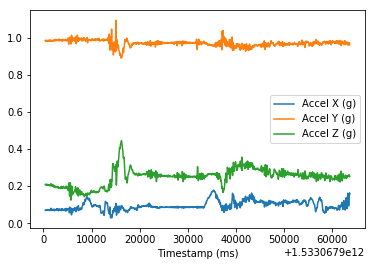

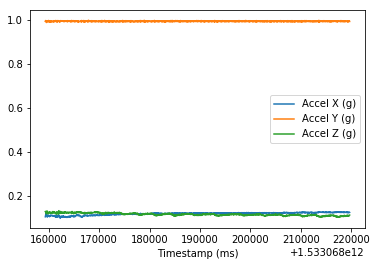

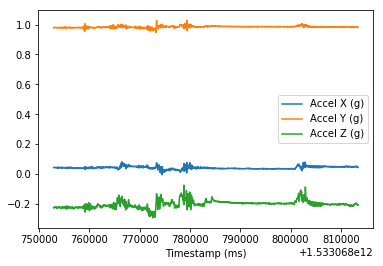

In [44]:
# sitting
df38.rawdata[183].plot()
df38.rawdata[231].plot()
df38.rawdata[279].plot()
df38.rawdata[327].plot()

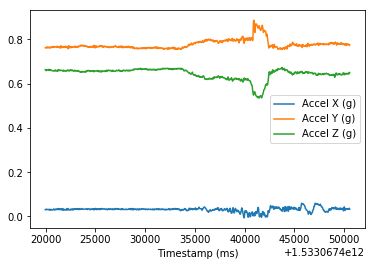

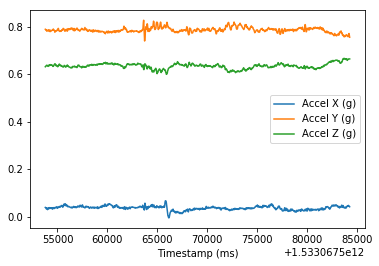

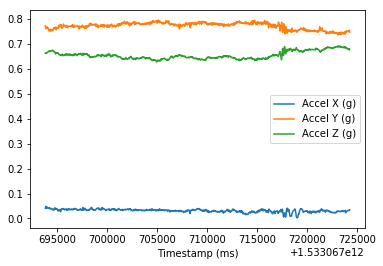

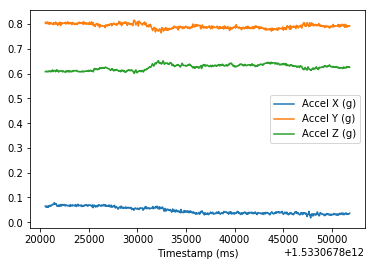

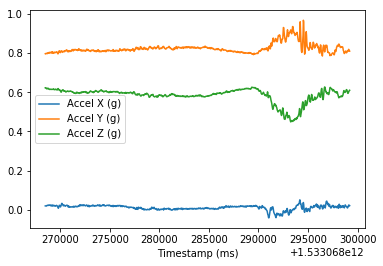

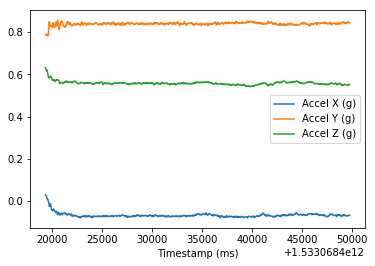

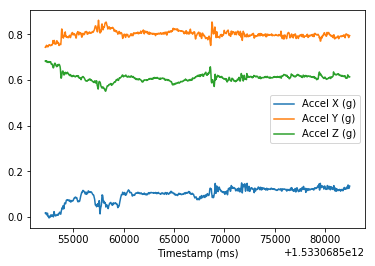

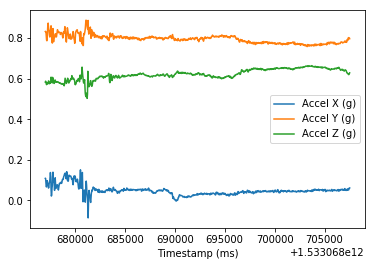

In [45]:
# standing
df38.rawdata[375].plot()
df38.rawdata[423].plot()
df38.rawdata[471].plot()
df38.rawdata[519].plot()
df38.rawdata[567].plot()
df38.rawdata[615].plot()
df38.rawdata[663].plot()
df38.rawdata[711].plot()

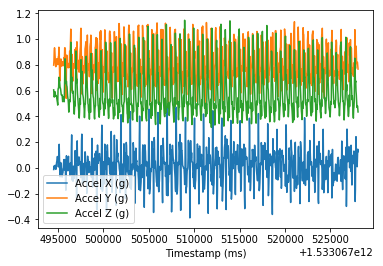

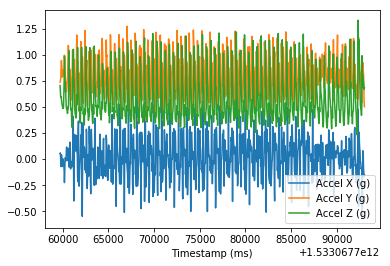

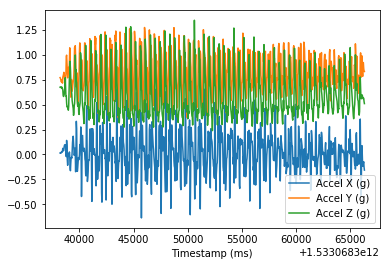

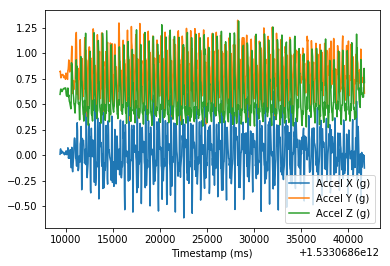

In [42]:
# walking
df38.rawdata[759].plot()
df38.rawdata[807].plot()
df38.rawdata[855].plot()
df38.rawdata[903].plot()

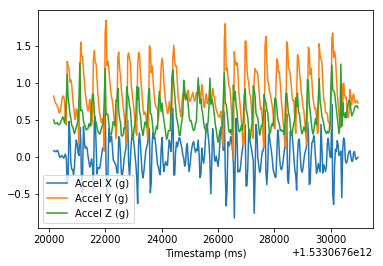

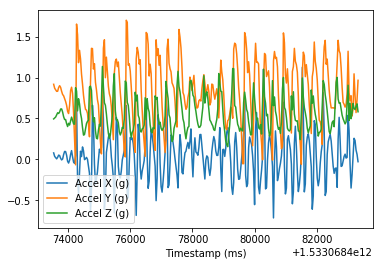

In [41]:
# stairs down
df38.rawdata[951].plot()
df38.rawdata[999].plot()

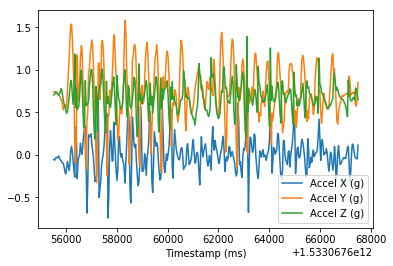

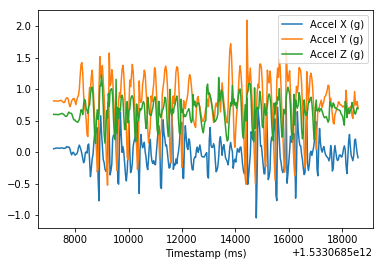

In [40]:
# stairs up
df38.rawdata[1047].plot()
df38.rawdata[1095].plot()